# Prevendo o Número de Matrículas das escolas

## Importando as tabelas

Tabelas usadas:

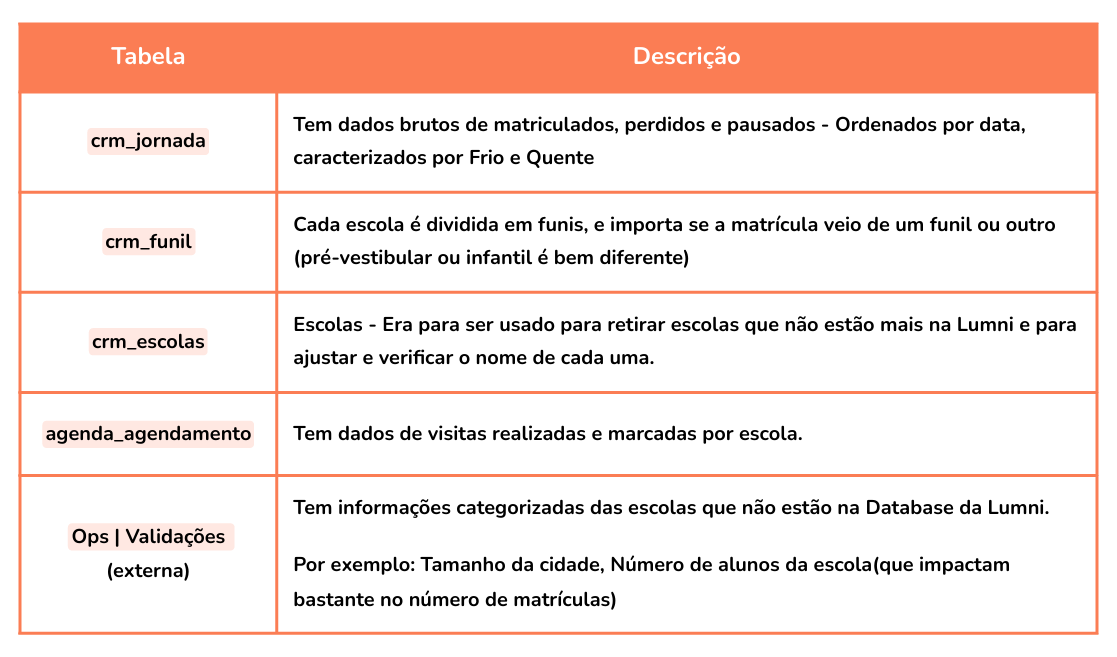


Vamos fazer um modelo para descobrir o número de matrículas previstas em cada mês;
A ideia principal e depois tentar aprimorar com séries temporais;

### Regressão Simples

As variáveis que vamos usar são:

- `Número de entrada de leads`
- `Número de visitas`
- `Número de candidatos Frios`
- `Números de candidatos Quentes`
- `Média de distância em dias entre entrada e agendamento`(velocidade)
- `Número de alunos da escola`
- `Número de habitantes da cidade`

**Observações**:
- O Mês não vai ser uma variável aqui, pois ele vai ser incorporado indiretamente via séries temporais, mas sim, ele é uma "variável" também
- Vamos juntar todos dados de todas as escolas e vamos treinar a Regressão, por isso incorporamos as duas últimas variáveis, apesar de não variarem com o mês
- Essa é a versão básica, só com a Regressão com essas variáveis, deveria ser possível ter uma estimativa bem legal do número de matrículas.

Para os modelos, testamos uma Regressão Linear e um modelo de árvore, XGBoost(que é recomendado para o nosso caso de )

### Séries Temporais

Para séries temporais, só usaremos o número de matrículas com o mês. O ideal é ter no mínimo 4 anos para ter uma previsão relativamente confiável e analisar tendência e sazonalidade. Isso aqui, diferentemente da Regressão, é feito para cada colégio, uma vez que cada um teria a sua peculiaridade(sendo assim, os parâmetros da regressão são captados de maneira indireta aqui).

Para o modelos, testamos apenas com o Facebook Prophet que é bem razoável para a nossa situação.

### Juntando Séries Temporais e Regressões

A ideia aqui é juntar as duas estratégias de algum modo; A maneira mais imediata de fazer isso seria:
- Inicialmente fazer a previsão da escola com séries temporais e captar o valor previsto, sazonalidade e tendência;
- Incorporar esses 3 parâmetros como variáveis da Regressão

**Observações**:
- Isso talvez não seja legal, porque dependendo da previsão via Séries Temporais, podemos enviezar o modelo de alguma forma
- Então se quisermos um modelo que se atualize a cada mês conforme o decorrer do mês(número de visitas, leads, etc), ou seja, a cada F5 da escola, o ideal é: 
    - Sempre retreinar o modelo de série temporal
    - Entretanto, acho que isso aqui(Drift) por si só tem complicações bem grandes, por não "fiscalizarmos" como o modelo performa;

- Opinião do Gollum:
    - Por que não atualizar mensalmente ao invés de cada F5? Assim temos mais controle em precisão.

### Importando bibliotecas

In [124]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

### Conexão com a base

In [125]:
from db_connect import connect_to_db

conn = connect_to_db()
if conn:
    cur = conn.cursor()
    
    # Consulta para listar as tabelas existentes no banco
    cur.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public';
    """)
    
    tables = cur.fetchall()

    tables = list(tables)
    tables = sorted(tables) 
    tabelas = []   
    if tables:
        print("Tabelas disponíveis no banco:")
        for table in tables:
            print(table[0])
            tabelas.append(table[0])
    else:
        print("Nenhuma tabela encontrada.")

    cur.close()
    conn.close()

Tabelas disponíveis no banco:
agenda_agendamento
agenda_calendarauthentication
agenda_calendariodisponivel
agenda_campodevolutivavisita
agenda_devolutivavisita
agenda_diadisponivel
agenda_escolhamultipladevolutivavisita
agenda_escolhaunicadevolutivavisita
agenda_horariodisponivel
agenda_valorcampodevolutivavisita
auth_group
auth_group_permissions
auth_permission
authentication_account
authentication_verificationtoken
captacao_botaosite
captacao_botaosite_dono
captacao_botaostatusurlsautorizadas
captacao_campoformulario
captacao_formulario
captacao_formulario_dono
captacao_landingpage
captacao_landingpage_dono
captacao_landingpagestatus
captacao_mensagempadronizada
captacao_metas
captacao_tipomensagempadronizada
crm_aluno
crm_anotacao
crm_campopersonalizado
crm_camposescolhamultipla
crm_camposescolhaunica
crm_comoconheceuescola
crm_escola
crm_escoladestino
crm_etapafunil
crm_funil
crm_historicointeracoes
crm_jornada
crm_jornadaetapa
crm_motivochurn
crm_origemlead
crm_registroconversa
cr

### Funções de Consulta

In [126]:
def verificar_colunas(table):
    conn = connect_to_db()
    if conn:
        cur = conn.cursor()
        query = """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = %s;
        """
        cur.execute(query, (table,))

        columns = cur.fetchall()

        print(f"Colunas na tabela {table}:")
        colunas = []
        for column in columns:
            colunas.append(column[0])

        cur.close()
        conn.close()
        return colunas

In [127]:
def get_dataframe(table, columns = None):
    conn = connect_to_db()
    if conn:
        cur = conn.cursor()

        if columns is None:
            cols_str = '*'
        else:
            cols_str = ', '.join(columns)

        cur.execute(f"SELECT {cols_str} FROM {table};")
        rows = cur.fetchall()

        if columns is None:
            columns = [desc[0] for desc in cur.description]

        df = pd.DataFrame(rows, columns=columns)

        cur.close()
        conn.close()

        return df

## Avaliando e Agrupando os dados - @Guru, se quiser pode pular essa parte

### Verificando as escolas existentes e removendo as que foram deletadas

In [128]:
escolas = pd.DataFrame(get_dataframe('crm_escola', ['id', 'created_at', 'deleted_at', 'nome']))
escolas.head()

,id,created_at,deleted_at,nome
0,2,2023-09-18 14:44:38+00:00,None,Aldeia
1,3,2023-09-18 14:59:04+00:00,None,Colégio Inovar Veiga de Almeida
2,4,2023-09-18 14:59:24+00:00,None,Colégio Época Inova+
3,5,2023-09-18 15:00:09+00:00,None,Colégio Ativa Idade
4,6,2023-09-19 06:27:14+00:00,None,Escola Vila Lume


Não temos dados de escolas deletadas:

In [129]:
escolas['deleted_at'].notna().sum()

np.int64(0)

In [130]:
escolas = escolas.drop(columns = 'deleted_at')
escolas.head()

,id,created_at,nome
0,2,2023-09-18 14:44:38+00:00,Aldeia
1,3,2023-09-18 14:59:04+00:00,Colégio Inovar Veiga de Almeida
2,4,2023-09-18 14:59:24+00:00,Colégio Época Inova+
3,5,2023-09-18 15:00:09+00:00,Colégio Ativa Idade
4,6,2023-09-19 06:27:14+00:00,Escola Vila Lume


### Ver as Jornadas - onde tem dados de matrículas

In [131]:
jornada = get_dataframe('crm_jornada')
jornada.head()

,id,created_at,updated_at,date_churn,date_matricula,aluno_id,funil_id,usuario_responsavel_id,status,termometro,motivo_churn_id,turma_id,turno_id,escola_id,principal,etapa_atual_id,etapa_atual_date_in,escola_destino_id,deleted_at
0,47359,2023-09-24 20:14:13.179000+00:00,2024-03-01 11:43:48.704087+00:00,NaT,2024-03-01 11:43:48.692561+00:00,70145,239,64,MATRICULADO,FRIO,NaN,NaN,NaN,9,True,1247,2024-03-01 11:43:48.695006+00:00,NaN,None
1,123691,2024-11-16 11:49:22.941720+00:00,2024-12-10 16:04:14.885341+00:00,2024-12-10 16:04:14.867322+00:00,NaT,186860,480,332,PERDIDO,FRIO,1397.0,2210.0,NaN,71,True,2667,2024-11-22 17:16:01.929783+00:00,NaN,None
2,83706,2024-08-02 20:53:51.741959+00:00,2025-01-14 14:59:57.789240+00:00,2024-08-06 13:23:40.537929+00:00,NaT,121537,365,146,PERDIDO,FRIO,1180.0,1869.0,NaN,36,True,1944,2025-01-14 14:59:57.767568+00:00,NaN,None
3,58386,2023-03-31 11:30:00+00:00,2023-03-31 11:30:00+00:00,NaT,2023-03-31 00:00:00+00:00,84686,287,94,MATRICULADO,FRIO,NaN,1549.0,NaN,25,True,1515,2023-03-31 11:30:00+00:00,NaN,None
4,68257,2024-04-25 00:24:32.478443+00:00,2024-04-25 00:24:32.478443+00:00,2024-01-01 00:00:00+00:00,NaT,104077,311,110,PERDIDO,FRIO,NaN,1597.0,NaN,32,True,1638,2024-04-25 00:24:32.478443+00:00,NaN,None


In [132]:
jornada['status'].value_counts()

status
PERDIDO         51568
EM_ANDAMENTO    25886
MATRICULADO     13059
PAUSADO          1293
Name: count, dtype: int64

Agrupando por data

In [133]:
jornada['updated_at'] = pd.to_datetime(jornada['updated_at']).dt.date
matriculas = jornada.groupby(['updated_at', 'escola_id']).agg(
    total=('escola_id', 'count'),
    quentes=('termometro', lambda x: (x == 'QUENTE').sum()),
    frios=('termometro', lambda x: (x == 'FRIO').sum()),
    matriculas=('status', lambda x: (x == 'MATRICULADO').sum()),
    perdidos=('status', lambda x: (x == 'PERDIDO').sum())
).reset_index()

matriculas

,updated_at,escola_id,total,quentes,frios,matriculas,perdidos
0,2019-02-12,39,1,0,1,0,0
1,2019-05-12,39,4,0,4,0,0
2,2019-06-12,39,1,0,1,0,0
3,2019-10-12,39,1,0,1,0,0
4,2019-11-12,39,1,0,1,1,0
...,...,...,...,...,...,...,...
7981,2025-03-28,99,1,0,1,0,0
7982,2025-03-28,102,3,0,3,0,0
7983,2025-03-28,103,6,0,6,0,1
7984,2025-03-28,104,2,0,2,1,0


Agrupando por mês-ano

In [134]:
jornada['updated_at'] = pd.to_datetime(jornada['updated_at'])

jornada['updated_month'] = jornada['updated_at'].dt.to_period("M")

# Agregação por mês e escola_id
matriculas_mensais = jornada.groupby(['updated_month', 'escola_id']).agg(
    total=('escola_id', 'count'),
    quentes=('termometro', lambda x: (x == 'QUENTE').sum()),
    frios=('termometro', lambda x: (x == 'FRIO').sum()),
    matriculas=('status', lambda x: (x == 'MATRICULADO').sum()),
    perdidos=('status', lambda x: (x == 'PERDIDO').sum())
).reset_index()

# Converter `updated_month` para string para exibição
matriculas_mensais['updated_month'] = matriculas_mensais['updated_month'].astype(str)

# Exibir resultado
matriculas_mensais

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos
0,2019-02,39,1,0,1,0,0
1,2019-05,39,4,0,4,0,0
2,2019-06,39,1,0,1,0,0
3,2019-10,39,1,0,1,0,0
4,2019-11,39,8,0,8,4,0
...,...,...,...,...,...,...,...
787,2025-03,102,2257,1,2253,337,1256
788,2025-03,103,1620,2,1618,219,799
789,2025-03,104,1159,173,867,215,265
790,2025-03,105,1593,571,352,334,1181


In [135]:
matriculas_mensais['mês'] = pd.to_datetime(matriculas_mensais['updated_month']).dt.month
matriculas_mensais['updated_month'] = pd.to_datetime(matriculas_mensais['updated_month']).dt.strftime('%m-%Y')

matriculas_mensais.head()

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos,mês
0,02-2019,39,1,0,1,0,0,2
1,05-2019,39,4,0,4,0,0,5
2,06-2019,39,1,0,1,0,0,6
3,10-2019,39,1,0,1,0,0,10
4,11-2019,39,8,0,8,4,0,11


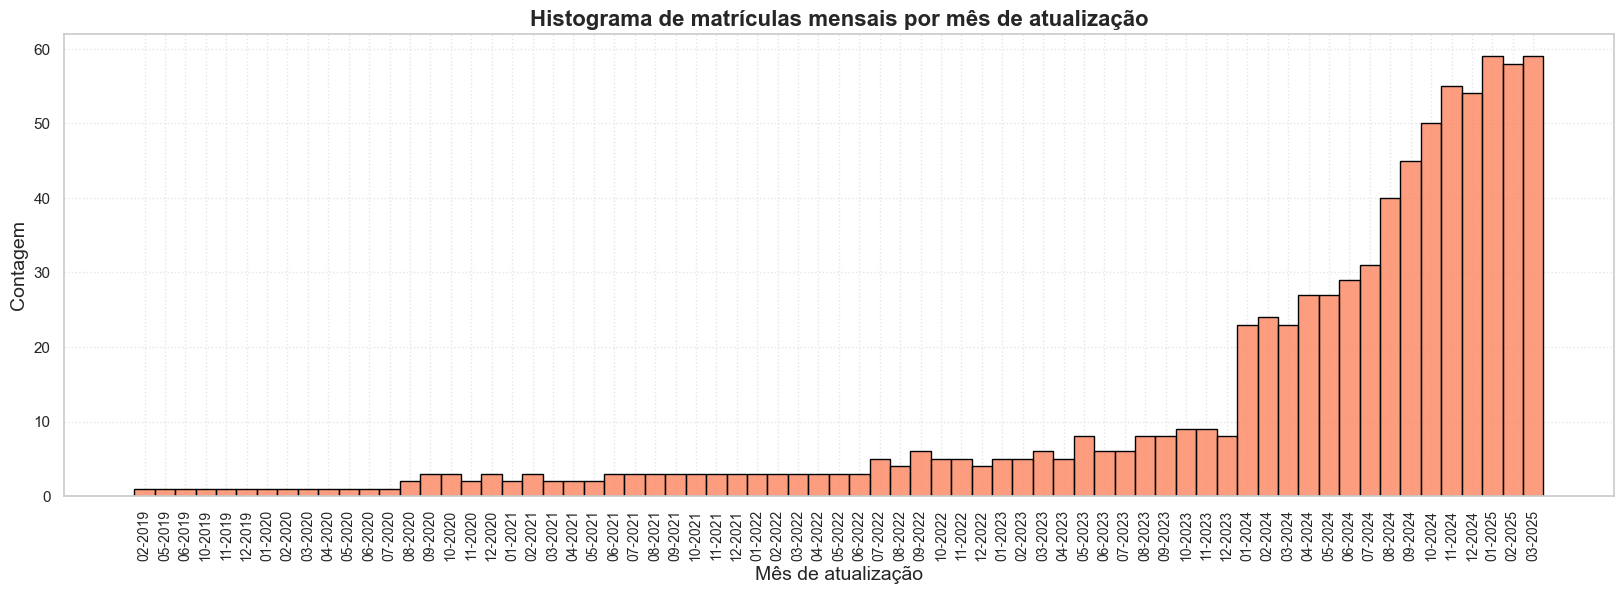

In [136]:
sns.set_style("whitegrid", {
    "axes.edgecolor": ".8",
    "grid.color": ".9",    
    "grid.linestyle": ":",
    "axes.grid": True
})

plt.figure(figsize=(20, 6))

sns.histplot(
    data=matriculas_mensais, 
    x='updated_month', 
    color='#FC7D55', 
    edgecolor='black'
)

plt.title("Histograma de matrículas mensais por mês de atualização", fontsize=16, fontweight='bold')
plt.xlabel("Mês de atualização", fontsize=14)
plt.ylabel("Contagem", fontsize=14)

plt.xticks(rotation=90, fontsize=10)


plt.show()

### Procurando por outras variáveis, como número de Leads e Visitas

In [137]:
verificar_colunas('agenda_agendamento')

Colunas na tabela agenda_agendamento:


['deleted_at',
 'created_at',
 'updated_at',
 'date_inicio',
 'date_fim',
 'created_by_id',
 'escola_id',
 'jornada_id',
 'usuario_responsavel_id',
 'responsavel_id',
 'id',
 'tipo',
 'motivo_ausente',
 'description',
 'location',
 'status',
 'id_evento',
 'meet_link',
 'calendar_link',
 'summary',
 'outro_motivo']

In [138]:
agendamento = get_dataframe('agenda_agendamento', ['usuario_responsavel_id', 'responsavel_id', 'updated_at', 'date_inicio', 'date_fim', 'escola_id', 'status'])
agendamento.head()

,usuario_responsavel_id,responsavel_id,updated_at,date_inicio,date_fim,escola_id,status
0,205,156515,2024-11-29 16:26:52.920481+00:00,2024-11-28 11:00:00+00:00,2024-11-28 11:30:00+00:00,40,realizado
1,5,67236,2024-03-06 17:15:25.549098+00:00,2024-03-08 18:30:00+00:00,2024-03-08 19:00:00+00:00,2,tentative
2,5,70344,2024-03-06 17:42:58.314038+00:00,2024-03-08 14:00:00+00:00,2024-03-08 15:00:00+00:00,2,tentative
3,5,70349,2024-03-07 17:33:18.366014+00:00,2024-03-08 18:00:00+00:00,2024-03-08 18:30:00+00:00,2,tentative
4,93,70383,2024-03-14 11:38:50.748843+00:00,2024-03-06 15:00:00+00:00,2024-03-06 15:15:00+00:00,20,realizado


In [139]:
agendamento['updated_at'] = pd.to_datetime(agendamento['updated_at'])

agendamento['updated_month'] = agendamento['updated_at'].dt.strftime('%m-%Y')

# Filtrar apenas os status finais
agendamento = agendamento.sort_values(['escola_id', 'updated_at', 'status'])
agendamento_final = agendamento.drop_duplicates(subset=['responsavel_id', 'escola_id', 'updated_at'], keep='last')

# Agrupar por mês-ano e escola_id
visitas_mensais = agendamento_final.groupby(['updated_month', 'escola_id']).agg(
    realizadas=('status', lambda x: (x == 'realizado').sum()),
    agendamentos=('status', lambda x: (x == 'tentative').sum())
).reset_index()

visitas_mensais

,updated_month,escola_id,realizadas,agendamentos
0,01-2025,1,5,0
1,01-2025,2,2,0
2,01-2025,5,22,0
3,01-2025,7,42,2
4,01-2025,9,128,2
...,...,...,...,...
335,12-2024,55,29,2
336,12-2024,76,58,11
337,12-2024,77,1,0
338,12-2024,78,1,0


Perceba que só temos dados de visitas de 2024 em diante

In [140]:
visitas_mensais['updated_month'].unique()

array(['01-2025', '02-2025', '03-2024', '03-2025', '04-2024', '05-2024',
       '06-2024', '07-2024', '08-2024', '09-2024', '10-2024', '11-2024',
       '12-2024'], dtype=object)

### Acoplando informações das escolas

In [141]:
escolas_info = pd.read_excel('escolas.xlsx', sheet_name='2025 | Escolas Lumni')
escolas_info = escolas_info[['Escolas', 'Categoria', 'Categoria.1', 'Id']]
escolas_info.rename(columns={'Categoria': 'Habitantes', 'Categoria.1': 'Número de alunos', 'Id': 'escola_id'}, inplace= True)
escolas_info.head()

,Escolas,Habitantes,Número de alunos,escola_id
0,Aldeia,Entre 300.001 e 1.000.000 hab.,Até 150 alunos,NaN
1,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,40.0
2,Centro Educacional Construindo o Futuro,Entre 300.001 e 1.000.000 hab.,Até 150 alunos,NaN
3,Colégio Alfredo Dantas,Entre 300.001 e 1.000.000 hab.,Acima de 900 alunos,NaN
4,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,25.0


In [142]:
escolas_info = escolas_info.dropna(subset= 'escola_id').reset_index(drop = True)
escolas_info['escola_id'] = escolas_info['escola_id'].astype('int64')
escolas_ref_id = escolas_info['escola_id'].unique()
escolas_info

,Escolas,Habitantes,Número de alunos,escola_id
0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,40
1,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,25
2,Colégio Brasília,Acima de 1.000.000 hab.,Acima de 900 alunos,95
3,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos,42
4,Colégio Inovar Veiga de Almeida,Acima de 1.000.000 hab.,Entre 151 e 300 alunos,3
5,Colégio PXS Flamboyant,Acima de 1.000.000 hab.,Até 150 alunos,7
6,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos,72
7,Escola Ativa Idade,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,5
8,Escola Educarte,Até 100.000 hab.,Entre 501 e 900 alunos,10
9,Escola Gênesis Stella Maris,Acima de 1.000.000 hab.,Entre 501 e 900 alunos,9


Juntando as informações que temos

In [143]:
df = visitas_mensais.merge(escolas_info, how = 'right', on = 'escola_id')
df

,updated_month,escola_id,realizadas,agendamentos,Escolas,Habitantes,Número de alunos
0,01-2025,40,26,21,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
1,02-2025,40,26,31,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
2,03-2025,40,8,20,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
3,08-2024,40,35,0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
4,09-2024,40,103,4,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
...,...,...,...,...,...,...,...
83,11-2024,11,9,1,Instituto Nossa Senhora da Piedade - Unidade F...,Acima de 1.000.000 hab.,Entre 501 e 900 alunos
84,12-2024,11,10,0,Instituto Nossa Senhora da Piedade - Unidade F...,Acima de 1.000.000 hab.,Entre 501 e 900 alunos
85,02-2025,12,2,0,Instituto Nossa Senhora da Piedade - Unidade J...,Acima de 1.000.000 hab.,Acima de 900 alunos
86,05-2024,12,3,0,Instituto Nossa Senhora da Piedade - Unidade J...,Acima de 1.000.000 hab.,Acima de 900 alunos


In [144]:
matriculas_mensais = matriculas_mensais[matriculas_mensais['escola_id'].isin(escolas_ref_id)]
matriculas_mensais.merge(escolas_info, how = 'left', on = 'escola_id')

,updated_month,escola_id,total,quentes,frios,matriculas,perdidos,mês,Escolas,Habitantes,Número de alunos
0,08-2020,40,2,0,2,1,1,8,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
1,09-2020,40,6,0,6,1,5,9,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
2,10-2020,40,10,0,10,0,10,10,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
3,11-2020,40,5,0,5,0,5,11,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
4,12-2020,40,2,0,2,0,2,12,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,71,3,67,10,41,3,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos
190,03-2025,40,386,17,368,37,252,3,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos
191,03-2025,42,83,2,79,3,53,3,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos
192,03-2025,72,4,0,3,0,2,3,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos


Juntando com os dados de matrícula:

In [145]:
matriculas_mensais = matriculas_mensais[matriculas_mensais['escola_id'].isin(escolas_ref_id)]
matriculas_mensais = matriculas_mensais.merge(escolas_info, how = 'left', on = 'escola_id')
df = df.merge(matriculas_mensais, on=['escola_id', 'updated_month', 'Escolas', 'Habitantes', 'Número de alunos'], how='right')
df

,updated_month,escola_id,realizadas,agendamentos,Escolas,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
0,08-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,2,0,2,1,1,8
1,09-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,6,0,6,1,5,9
2,10-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,10,0,10,0,10,10
3,11-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,5,0,5,0,5,11
4,12-2020,40,NaN,NaN,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,2,0,2,0,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,0.0,1.0,Colégio Anglo Taubaté,Entre 300.001 e 1.000.000 hab.,Entre 301 e 500 alunos,71,3,67,10,41,3
190,03-2025,40,8.0,20.0,Caminhos e Colinas,Acima de 1.000.000 hab.,Acima de 900 alunos,386,17,368,37,252,3
191,03-2025,42,NaN,NaN,Colégio Educallis,Acima de 1.000.000 hab.,Acima de 900 alunos,83,2,79,3,53,3
192,03-2025,72,NaN,NaN,Colégio Única Master,Até 100.000 hab.,Entre 501 e 900 alunos,4,0,3,0,2,3


## Estudando os dados

In [146]:
df.describe()

,escola_id,realizadas,agendamentos,total,quentes,frios,matriculas,perdidos,mês
count,194.000000,88.000000,88.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,23.015464,22.988636,2.784091,147.185567,9.670103,133.804124,28.572165,92.690722,6.041237
std,17.864045,28.891988,5.985517,339.633400,20.020571,330.586122,69.531425,215.934641,3.682806
min,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,9.000000,3.750000,0.000000,21.250000,0.000000,17.500000,2.000000,11.000000,3.000000
50%,12.000000,13.000000,1.000000,64.000000,1.000000,52.500000,9.000000,35.500000,6.000000
75%,40.000000,28.500000,3.000000,149.000000,10.000000,134.000000,28.750000,93.750000,9.000000
max,95.000000,149.000000,31.000000,3963.000000,118.000000,3960.000000,784.000000,2618.000000,12.000000


Temos muitos dados nulos, principalmente em visitas; Qual a saída?

Preenchendo os dados de visitas realizadas e tentativas com KNN;

O KNN avalia por meio da distância euclidiana as linhas mais parecidas entre si(que tem menor distância) - Vai preencher os valores de visitas e agendamentos provavelmente com a média das _k_ linhas mais próximas.

In [147]:
habitantes_map = {
    'Até 100.000 hab.': 1,
    'Entre 100.001 e 300.000 hab.': 2,
    'Entre 300.001 e 1.000.000 hab.': 3,
    'Acima de 1.000.000 hab.': 4
}

alunos_map = {
    'Até 300 alunos': 1,
    'Entre 301 e 500 alunos': 2,
    'Entre 501 e 900 alunos': 3,
    'Acima de 900 alunos': 4
}

df['Habitantes'] = df['Habitantes'].map(habitantes_map)
df['Número de alunos'] = df['Número de alunos'].map(alunos_map)



cols_to_impute = ['realizadas', 'agendamentos', 'Habitantes', 'Número de alunos', 'quentes', 'frios', 'matriculas', 'perdidos', 'mês']
df_knn = df[cols_to_impute].copy()

imputer = KNNImputer(n_neighbors=5)

# Aplica o KNN para preencher valores
df_imputed = imputer.fit_transform(df_knn)

# Atualiza o DataFrame original com os valores imputados
df[cols_to_impute] = pd.DataFrame(df_imputed, columns=cols_to_impute)

df

,updated_month,escola_id,realizadas,agendamentos,Escolas,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
0,08-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,2,0.0,2.0,1.0,1.0,8.0
1,09-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,6,0.0,6.0,1.0,5.0,9.0
2,10-2020,40,14.2,0.6,Caminhos e Colinas,4.0,4.0,10,0.0,10.0,0.0,10.0,10.0
3,11-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,5,0.0,5.0,0.0,5.0,11.0
4,12-2020,40,6.4,0.2,Caminhos e Colinas,4.0,4.0,2,0.0,2.0,0.0,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,03-2025,25,0.0,1.0,Colégio Anglo Taubaté,3.0,2.0,71,3.0,67.0,10.0,41.0,3.0
190,03-2025,40,8.0,20.0,Caminhos e Colinas,4.0,4.0,386,17.0,368.0,37.0,252.0,3.0
191,03-2025,42,22.6,0.8,Colégio Educallis,4.0,4.0,83,2.0,79.0,3.0,53.0,3.0
192,03-2025,72,6.4,0.2,Colégio Única Master,1.0,3.0,4,0.0,3.0,0.0,2.0,3.0


In [148]:
df.describe()

,escola_id,realizadas,agendamentos,Habitantes,Número de alunos,total,quentes,frios,matriculas,perdidos,mês
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,23.015464,18.380412,2.117526,3.479381,3.235052,147.185567,9.670103,133.804124,28.572165,92.690722,6.041237
std,17.864045,20.852123,4.516338,0.950641,0.761515,339.633400,20.020571,330.586122,69.531425,215.934641,3.682806
min,3.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,9.000000,6.400000,0.200000,3.000000,3.000000,21.250000,0.000000,17.500000,2.000000,11.000000,3.000000
50%,12.000000,12.400000,1.000000,4.000000,3.000000,64.000000,1.000000,52.500000,9.000000,35.500000,6.000000
75%,40.000000,22.900000,1.800000,4.000000,4.000000,149.000000,10.000000,134.000000,28.750000,93.750000,9.000000
max,95.000000,149.000000,31.000000,4.000000,4.000000,3963.000000,118.000000,3960.000000,784.000000,2618.000000,12.000000


Somente para organização, vamos colocar a variável alvo em último

In [149]:
df['matriculas'] = df.pop('matriculas')

## Aplicando Modelos

### Começando com uma regressão linear

Verificando a relação entre as variáveis

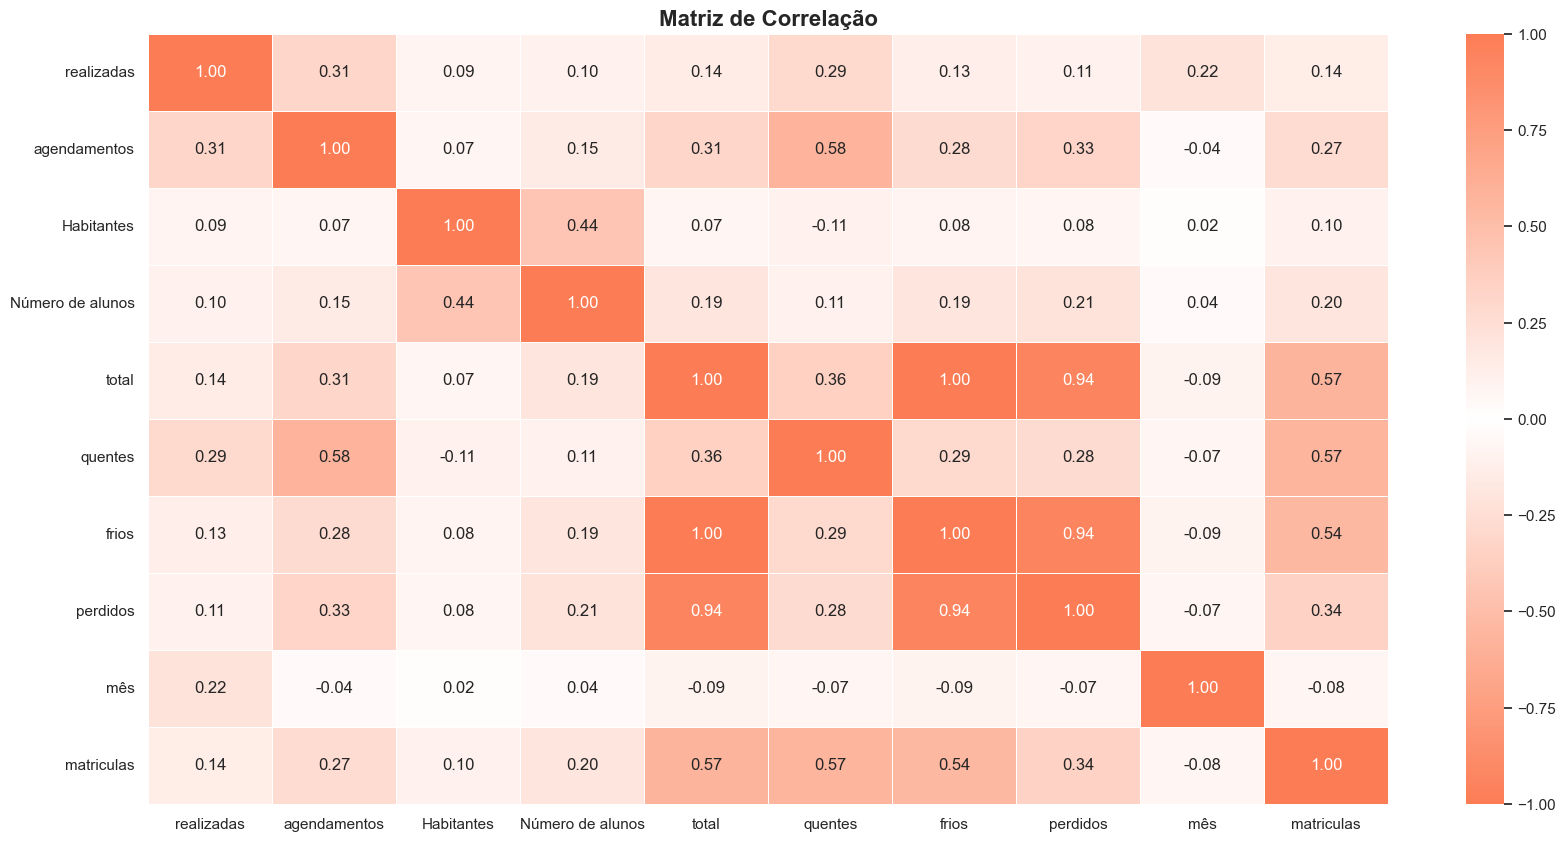

In [150]:
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "orange_diverging",
    [
        (0.0, "#FC7D55"),
        (0.5, "#FFFFFF"), 
        (1.0, "#FC7D55")   
    ]
)

norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

matriz_corr = df.drop(columns=['updated_month', 'escola_id', 'Escolas']).corr()

plt.figure(figsize=(20, 10))
sns.heatmap(
    data=matriz_corr,
    cmap=cmap_custom,
    norm=norm,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor="white"
)

plt.title("Matriz de Correlação", fontsize=16, fontweight='bold')
plt.show()

In [151]:
dados_brutos = df

Analisando a matriz de correlação apenas na linha de número de matrículas, todas as nossas informações apresentam correlação significativa. É importante citar que a correlação baixa em mês se refere ao fato de que temos um número muito grande de meses com poucas matrículas, então talvez valeria a pena agrupar por bimestre, por exemplo. Como não é o nosso foco, esperamos que pelo menos um modelo de árvore possa identificar as tendências

In [152]:
df = df.drop(columns = ['updated_month', 'escola_id', 'Escolas'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   realizadas        194 non-null    float64
 1   agendamentos      194 non-null    float64
 2   Habitantes        194 non-null    float64
 3   Número de alunos  194 non-null    float64
 4   total             194 non-null    int64  
 5   quentes           194 non-null    float64
 6   frios             194 non-null    float64
 7   perdidos          194 non-null    float64
 8   mês               194 non-null    float64
 9   matriculas        194 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 15.3 KB


Transformando as colunas em categóricas

In [153]:
df['mês'] = df['mês'].astype('category')

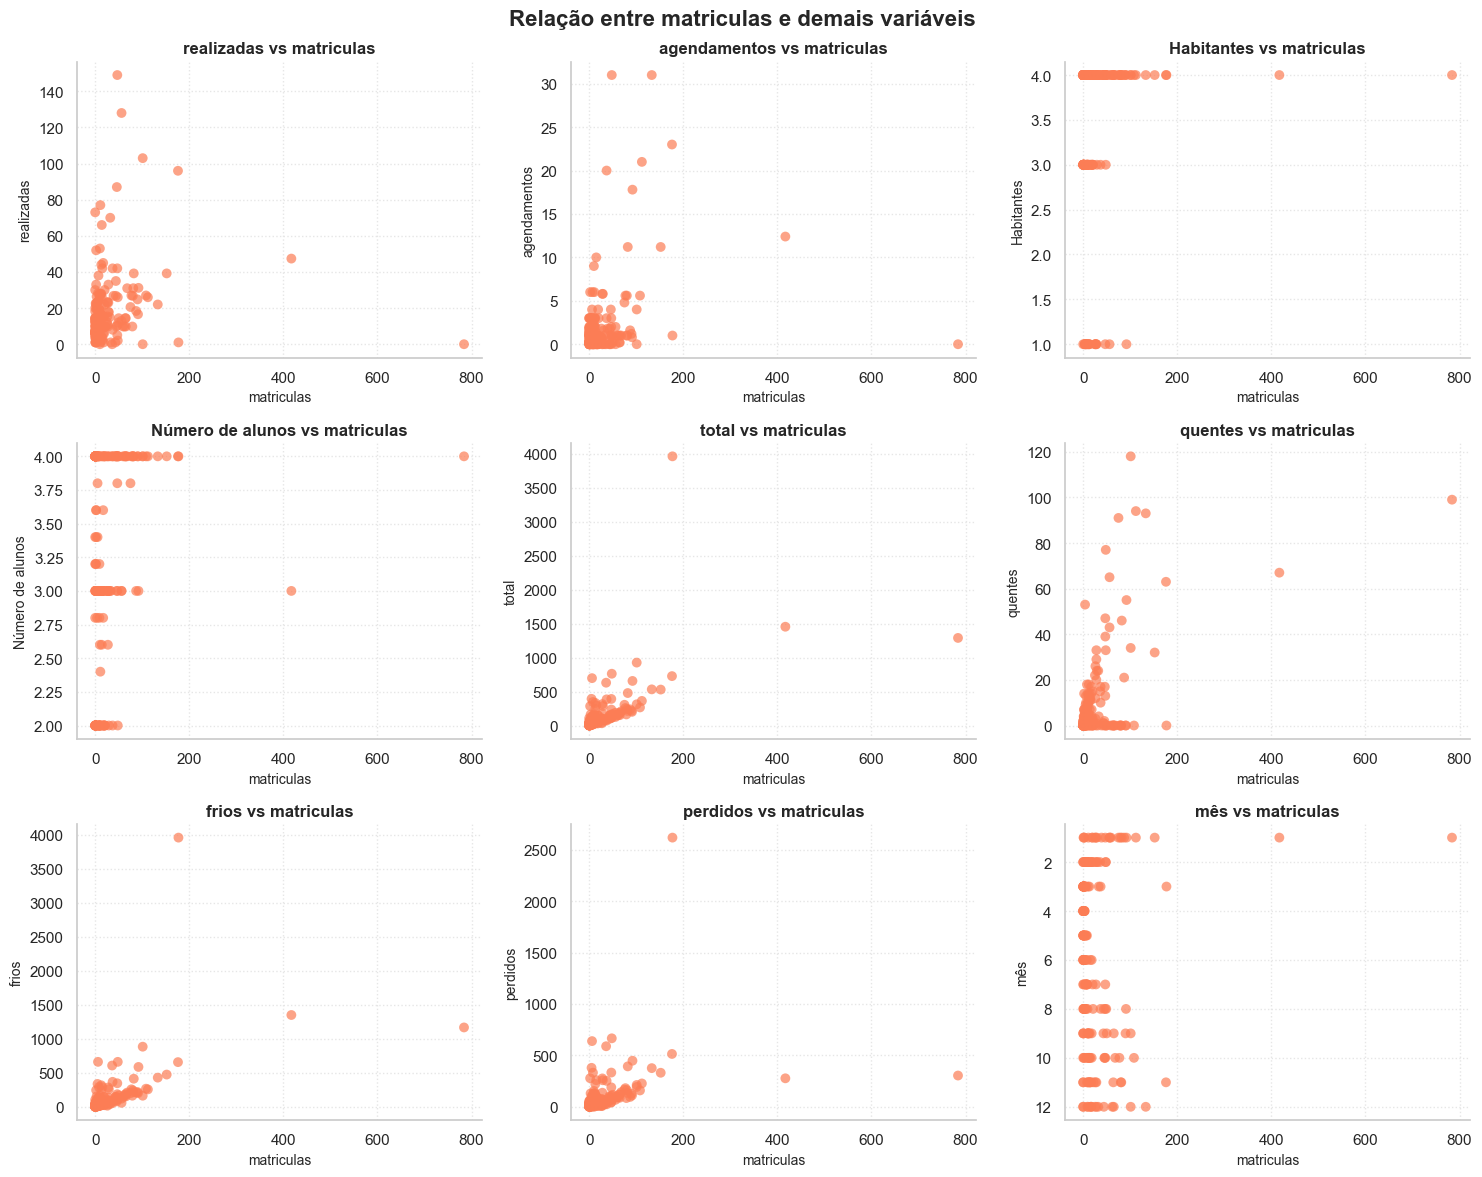

In [154]:
# Define um estilo de grade suave
sns.set_theme(style="whitegrid", rc={
    "grid.color": ".9",
    "grid.linestyle": ":",
})

coluna_referencia = 'matriculas'
variaveis = [col for col in df.columns if col != coluna_referencia]

n = len(variaveis)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(variaveis, start=1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(
        data=df,
        x=coluna_referencia,
        y=col,
        color="#FC7D55",
        s=50,     
        alpha=0.7,
        edgecolor="none"
    )
    plt.title(f"{col} vs {coluna_referencia}", fontsize=12, fontweight="bold")
    plt.xlabel(coluna_referencia, fontsize=10)
    plt.ylabel(col, fontsize=10)

# Suptítulo geral
plt.suptitle("Relação entre matriculas e demais variáveis", 
             fontsize=16, fontweight='bold')

plt.tight_layout()

# Remove bordas superiores e direitas
sns.despine()

plt.show()

Vamos manter os outliers do jeito que estão, apesar de ser relativamente errado fazer isso, mas não temos muitos dados

Na regressão, para transformar os dados, vamos usar one-hot encoding para categóricas, entretanto, como temos 12 meses, a matriz vai ficar bem esparsa;

O ideal aqui é ter uma variável índice do mês:

Ex:

- Mês quente: Nov, Dez, Jan -> indice = 2
- Mês morno: Jul, Jun (não sei bem) -> indice = 1
- Mês frio: índice = 0

E isso aqui a série temporal seria bizu:
- O modelo de série iria cuspir a trend, sazon e ruído do mês, e isso seria transformado nesse índice;
- Desse jeito seria mais preciso, a gente ia poder considerar o crescimento do colégio, período, melhor do que uma análise mais simples que nem eu propus em cima. Enquanto isso não chega, vou manter o de cima

Vamos testar os dois casos(deixando a matriz esparsa e outra abordagem com os índices)

# Modelos
## Regressão
### Começando com uma regressão linear com OLS

Dividindo em explicativas e alvo

In [155]:
def classificar_mes(mes):
    if mes in [10, 11, 12, 1]:
        return 2 # quente
    elif mes in [2, 3, 7, 8, 9]: 
        return 1 # morno
    else:
        return 0 # frio

df['mes_indic'] = df['mês'].apply(classificar_mes)

In [156]:
# explicativas(x)
x = df.drop(columns = ['matriculas'], axis = 1)
# alvo(y)
y = df['matriculas'].copy()

In [ ]:
x['mês'] = x['mês'].astype('int64')
colunas_categ = ['mês']

one_hot = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse_output=False), colunas_categ),
    remainder='passthrough'
)

x_transf = one_hot.fit_transform(x)

nomes_categ = one_hot.named_transformers_['onehotencoder'].get_feature_names_out(colunas_categ)
colunas_remainder = [col for col in x.columns if col not in colunas_categ]
novos_nomes_colunas = list(nomes_categ) + colunas_remainder

x1 = pd.DataFrame(x_transf, columns=novos_nomes_colunas)
x1.drop(columns= 'mes_indic', inplace = True)
x1

,mês_1,mês_2,mês_3,mês_4,mês_5,mês_6,mês_7,mês_8,mês_9,mês_10,mês_11,mês_12,realizadas,agendamentos,Habitantes,Número de alunos,total,quentes,frios,perdidos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.4,0.2,4.0,4.0,2.0,0.0,2.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.4,0.2,4.0,4.0,6.0,0.0,6.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.2,0.6,4.0,4.0,10.0,0.0,10.0,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.4,0.2,4.0,4.0,5.0,0.0,5.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.4,0.2,4.0,4.0,2.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,71.0,3.0,67.0,41.0
190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,20.0,4.0,4.0,386.0,17.0,368.0,252.0
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.6,0.8,4.0,4.0,83.0,2.0,79.0,53.0
192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4,0.2,1.0,3.0,4.0,0.0,3.0,2.0


Normalizando os dados para os modelos - não importa para árvores, mas é importante para modelos lineares

In [158]:
scaler = MinMaxScaler()
x1_scaled = scaler.fit_transform(x1)
x1 = pd.DataFrame(x1_scaled, columns=x1.columns, index=x1.index)
x1

,mês_1,mês_2,mês_3,mês_4,mês_5,mês_6,mês_7,mês_8,mês_9,mês_10,mês_11,mês_12,realizadas,agendamentos,Habitantes,Número de alunos,total,quentes,frios,perdidos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.042953,0.006452,1.000000,1.0,0.000252,0.000000,0.000253,0.000382
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.042953,0.006452,1.000000,1.0,0.001262,0.000000,0.001263,0.001910
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.095302,0.019355,1.000000,1.0,0.002272,0.000000,0.002273,0.003820
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.042953,0.006452,1.000000,1.0,0.001010,0.000000,0.001010,0.001910
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.042953,0.006452,1.000000,1.0,0.000252,0.000000,0.000253,0.000764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.032258,0.666667,0.0,0.017668,0.025424,0.016671,0.015661
190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053691,0.645161,1.000000,1.0,0.097173,0.144068,0.092700,0.096257
191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151678,0.025806,1.000000,1.0,0.020697,0.016949,0.019702,0.020244
192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042953,0.006452,0.000000,0.5,0.000757,0.000000,0.000505,0.000764


In [159]:
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size = 0.3, random_state = 7)

In [160]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)

reg_linear_1 = sm.OLS(y_train, X_train).fit()
print(reg_linear_1.summary())

                            OLS Regression Results                            
Dep. Variable:             matriculas   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     22.92
Date:                Fri, 28 Mar 2025   Prob (F-statistic):           1.68e-30
Time:                        15:55:37   Log-Likelihood:                -679.10
No. Observations:                 135   AIC:                             1398.
Df Residuals:                     115   BIC:                             1456.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.8638      9.976  

Beleza, nossa métrica que é o R2 tá até legal, mas note que tem valores p's bem maior que 5%, que é um problema - O resultado tá legal mas isso não significa nada.

Só por teste, acho interessante remover algumas variáveis redundantes, com baixa correlação(porque isso atrapalha o modelo linear) ou com pouca significância no modelo anterior, eu julguei como necessárias:


In [161]:
reg_linear_2 = sm.OLS(y_train, X_train.drop(columns =  ['agendamentos', 'frios', 'Habitantes'] + list(X_train.columns[X_train.columns.str.startswith('mês')]))).fit()
print(reg_linear_2.summary())

                            OLS Regression Results                            
Dep. Variable:             matriculas   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     87.19
Date:                Fri, 28 Mar 2025   Prob (F-statistic):           1.17e-39
Time:                        15:55:37   Log-Likelihood:                -685.10
No. Observations:                 135   AIC:                             1382.
Df Residuals:                     129   BIC:                             1400.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.6524      7.092  

In [162]:
X_test = sm.add_constant(X_test, has_constant='add')
predict1 = reg_linear_1.predict(X_test)
predict1

24      35.958973
133     52.743176
113     18.917171
22       9.092639
131     50.166626
192    -10.189408
46      16.463877
143     41.261981
154      6.931770
65      -0.265682
148     74.596100
173     25.692635
171     15.089097
98      12.250962
109     11.493541
85       2.669319
114      3.380910
134     25.424025
138     40.383691
74       3.796029
40      -5.955001
155     -9.787030
11      16.014134
150     -5.229516
99       3.578639
80      18.271311
129     21.492691
102     12.342903
94       2.848067
117      6.752263
181      9.180746
2       39.527378
178     57.442525
115     17.413527
27      39.308367
78     -12.280179
31     -12.182796
149     17.624899
32       3.707301
13      13.257244
116     14.945294
106      8.800408
124    -14.447473
57      53.539021
18      19.177906
126    -28.622182
164    113.817648
120     -5.357078
82       3.606322
60      18.644028
86      73.629024
36     -14.660753
45      54.015761
84     -13.991292
101    -21.905733
51      59

In [163]:
from sklearn.metrics import r2_score
print("R²: ", r2_score(y_test, predict1))

R²:  0.09519731706147916


In [164]:
predict2 = reg_linear_2.predict(X_test.drop(columns =  ['agendamentos', 'frios', 'Habitantes'] + list(X_train.columns[X_train.columns.str.startswith('mês')])))
predict2

24      37.039383
133     26.941726
113     19.088992
22      15.114135
131     36.669468
192      7.096600
46      -5.261084
143     17.838777
154     10.948934
65      -5.492115
148     66.433406
173     17.619558
171      6.919735
98      17.010542
109     12.856153
85       8.254605
114     11.977516
134      1.463406
138     15.888187
74      12.029263
40      -5.245029
155     -0.609650
11      16.767737
150      1.573944
99       6.191732
80      23.342097
129      5.323806
102     12.576876
94      16.704881
117     18.206683
181     18.247664
2       14.538730
178     48.858782
115     20.890044
27      23.561176
78       5.689711
31      -4.876924
149     22.795272
32      12.012967
13      21.320694
116     15.627253
106     14.421663
124     -2.310036
57      37.673640
18      14.857969
126     -8.102544
164    102.412810
120      8.495190
82      10.910319
60      11.271429
86      91.031642
36      -7.067694
45      34.598294
84      -4.876924
101    -12.472142
51      53

In [165]:
print("R²: ", r2_score(y_test, predict2))

R²:  0.13008745593024063


Ok. Resultado interessante do modelo 2, mesmo assim, eu não confiaria pelos motivos de cima. 

**Observações**:
- fazendo uns testes, o modelo 2 é muito sensível a `perdidos`


Uma segunda alternativa seria melhorar a variável mês e transformá-la em um índice indicando o quão "quente" o mês seria, mas desse jeito perderíamos um pouco da personalização de escola, então optei por remover essa parte do notebook 

Isso aqui é o que a série vai dar pra gente

### Usando um modelo de árvore
Aqui usaremos o XGBoost

In [166]:
x['mês'] = x['mês'].astype('category')
x['mes_indic'] = x['mes_indic'].astype('category')
x

,realizadas,agendamentos,Habitantes,Número de alunos,total,quentes,frios,perdidos,mês,mes_indic
0,6.4,0.2,4.0,4.0,2,0.0,2.0,1.0,8,1
1,6.4,0.2,4.0,4.0,6,0.0,6.0,5.0,9,1
2,14.2,0.6,4.0,4.0,10,0.0,10.0,10.0,10,2
3,6.4,0.2,4.0,4.0,5,0.0,5.0,5.0,11,2
4,6.4,0.2,4.0,4.0,2,0.0,2.0,2.0,12,2
...,...,...,...,...,...,...,...,...,...,...
189,0.0,1.0,3.0,2.0,71,3.0,67.0,41.0,3,1
190,8.0,20.0,4.0,4.0,386,17.0,368.0,252.0,3,1
191,22.6,0.8,4.0,4.0,83,2.0,79.0,53.0,3,1
192,6.4,0.2,1.0,3.0,4,0.0,3.0,2.0,3,1


In [167]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 7)

In [168]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error

dtreino = xgb.DMatrix(X_train.drop(columns = 'mes_indic'), y_train, enable_categorical=True)
dteste = xgb.DMatrix(X_test.drop(columns = 'mes_indic'), y_test, enable_categorical=True)

params = {'objective': 'reg:squarederror'}

xgboost_1 = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=100
)

preds = xgboost_1.predict(dteste)

rmse = root_mean_squared_error(dteste.get_label(), preds)
print(f'RMSE: {rmse:.2f}')

RMSE: 14.46


Avaliando overfitting

In [169]:
rmse = root_mean_squared_error(dtreino.get_label(), xgboost_1.predict(dtreino))
print(f'RMSE: {rmse:.2f}')

RMSE: 0.00


Deu overfitting! Vamos otimizar os hyperparametros

In [170]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    # colsample_bytree = número de features
    'colsample_bytree': [0.8, 1],
    # subsample = porcentagem da amostra
    'subsample': [0.5, 0.8, 1],
    'max_depth': [3, 5, 8, 10],
    'n_estimators': [100]
}

gbm = xgb.XGBRegressor(enable_categorical=True)

grid = GridSearchCV(
    estimator = gbm,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

grid.fit(x, y)

print('Melhores hiperparâmetros encontrados: ', grid.best_params_)
print('Menor RMSE encontrado: ', np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores hiperparâmetros encontrados:  {'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Menor RMSE encontrado:  52.09794872799302


In [171]:
params = {'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1, 'learning_rate': 0.01}

xgboost_1_final = xgb.train(
    params=params,
    dtrain=dtreino
)

preds = xgboost_1_final.predict(dteste)
rmse = root_mean_squared_error(dteste.get_label(), preds)
print(f'RMSE: {rmse:.2f}')

RMSE: 27.49


C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[15:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.




In [172]:
rmse = root_mean_squared_error(dtreino.get_label(), xgboost_1_final.predict(dtreino))
print(f'RMSE: {rmse:.2f}')

RMSE: 76.22


Para o nosso caso, é um erro quadrático muito alto. Vamos ver futuramente no gráfico

O modelo não deu overfitting, mas com certeza tem algo errado: O erro quadrático médio é bem maior no treino. Não recomendo usar esse modelo.

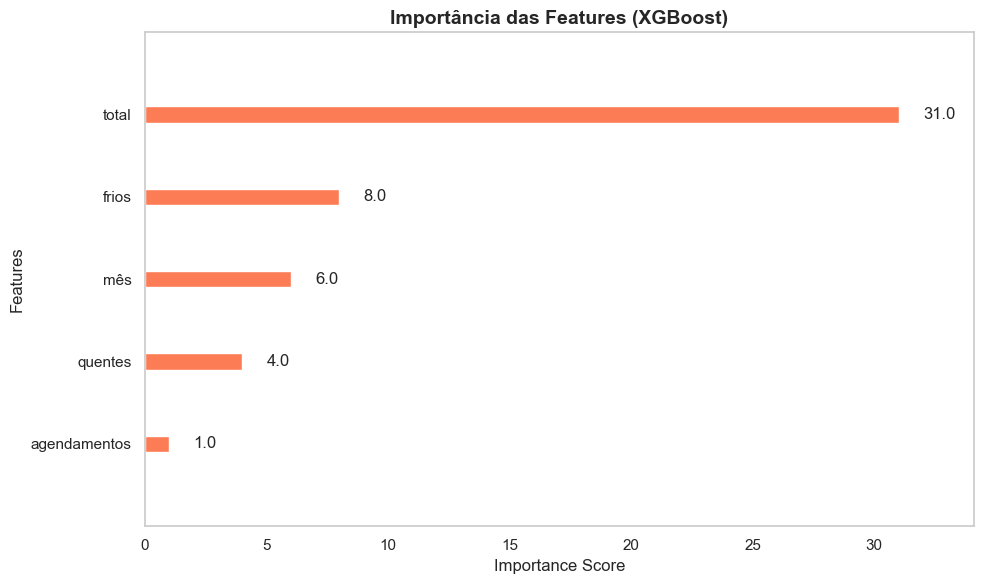

In [173]:
sns.set_theme(style="whitegrid", rc={"axes.grid": False})

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(
    xgboost_1_final,
    ax=ax,
    color="#FC7D55",
    grid=False,
    title=None 
)

ax.set_title("Importância das Features (XGBoost)", fontsize=14, fontweight="bold")
ax.set_xlabel("Importance Score", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

ax.grid(False)

plt.tight_layout()
plt.show()

Curiosamente o número de leads é o fator mais importante. Isso chama atenção, pois tem a maior correlação com matrículas, aqui pelo menos tivemos concordância.

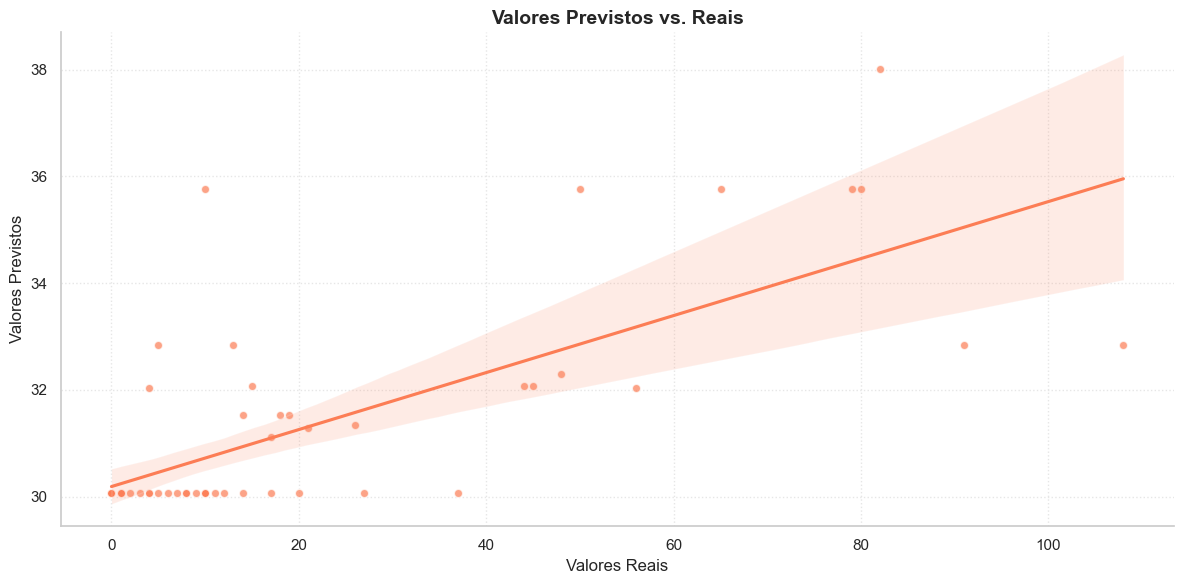

In [ ]:
sns.set_theme(style="whitegrid", rc={
    "grid.color": ".9",
    "grid.linestyle": ":",
})

plt.figure(figsize=(12, 6))

sns.regplot(
    x=y_test,
    y=preds,
    scatter_kws={"color": "#FC7D55", "alpha": 0.7, "edgecolor": "white"},
    line_kws={"color": "#FC7D55"} 
)

plt.xlabel("Valores Reais", fontsize=12)
plt.ylabel("Valores Previstos", fontsize=12)
plt.title("Valores Previstos vs. Reais", fontsize=14, fontweight="bold")


sns.despine()

plt.tight_layout()
plt.show()

Perceba que o erro quadrático médio estar tão alto não era atoa. Assim, à menos que cheguem mais dados, o modelo não consegue diferenciar bem com essas variáveis. Não usaremos essa estratégia por enquanto.

## Usando Séries Temporais

Primeiro vamos colocar a série temporal de todos os nossos colégios

In [175]:
dados_brutos['Escolas'].unique()

array(['Caminhos e Colinas', 'Colégio Anglo Taubaté',
       'Colégio Inovar Veiga de Almeida', 'Escola Ativa Idade',
       'Colégio PXS Flamboyant', 'Escola Gênesis Stella Maris',
       'Escola Educarte',
       'Instituto Nossa Senhora da Piedade - Unidade Flamengo',
       'Instituto Nossa Senhora da Piedade - Unidade Jacarepaguá',
       'Colégio Educallis', 'Colégio Única Master', 'Colégio Brasília'],
      dtype=object)

In [176]:
import plotly.express as px

df_grouped = dados_brutos.groupby(['updated_month', 'Escolas'], as_index=False)['matriculas'].sum()
df_grouped['updated_month'] = pd.to_datetime(df_grouped['updated_month'], format='%m-%Y')
df_grouped = df_grouped.sort_values('updated_month')

lista_escolas = ['Escola Gênesis Stella Maris', 'Colégio Inovar Veiga de Almeida', 'Escola Ativa Idade', 'Instituto Nossa Senhora da Piedade - Unidade Flamengo', 'Instituto Nossa Senhora da Piedade - Unidade Jacarepaguá']

fig = px.line(
    df_grouped[df_grouped['Escolas'].isin(lista_escolas)],
    x='updated_month',
    y='matriculas',
    color='Escolas',
    markers=True,
    title='Matrículas Mensais por Escola'
)

fig.update_layout(
    xaxis_title='Mês',
    yaxis_title='Total de Matrículas',
    legend_title='Escola',
    hovermode='x unified'
)

fig.show()


Perceba que em algumas(que eu deixei em destaque) temos que ignorar os primeiros dados, pois tratam provavelmente de dados antigos que a escola considerou como matrícula(Isso pode ser facilmente visto com o número de alunos da escola e porque não tem uma pico similar em janeiro).

In [177]:
import plotly.express as px

df_grouped = dados_brutos.groupby(['updated_month', 'Escolas'], as_index=False)['matriculas'].sum()
df_grouped['updated_month'] = pd.to_datetime(df_grouped['updated_month'], format='%m-%Y')
df_grouped = df_grouped.sort_values('updated_month')

lista_escolas = ['Escola Gênesis Stella Maris', 'Colégio Inovar Veiga de Almeida', 'Escola Ativa Idade', 'Instituto Nossa Senhora da Piedade - Unidade Flamengo', 'Instituto Nossa Senhora da Piedade - Unidade Jacarepaguá']

fig = px.line(
    df_grouped[df_grouped['Escolas'].isin(lista_escolas)],
    x='updated_month',
    y='matriculas',
    color='Escolas',
    markers=True,
    title='Matrículas Mensais por Escola'
)

fig.update_layout(
    xaxis_title='Mês',
    yaxis_title='Total de Matrículas',
    legend_title='Escola',
    hovermode='x unified'
)

fig.show()


O Caminhos e Colinas parece ter uma regularidade bem interessante em dados de outros anos.


O que vamos fazer agora é mostrar para o _Caminhos e Colinas_ como que é o processo, porque eles tem mais dados(apesar de ainda ser pouco para uma série temporal).

In [178]:
caminhos_colinas = dados_brutos[dados_brutos['Escolas'] == 'Caminhos e Colinas'].drop(columns= 'Escolas')
caminhos_colinas = caminhos_colinas[['updated_month', 'matriculas']]
# colocando dados de 2020 em diante
caminhos_colinas = caminhos_colinas[pd.to_datetime(caminhos_colinas['updated_month']).dt.year > 2020]
caminhos_colinas.head()

C:\Users\fealp\AppData\Local\Temp\ipykernel_37288\1311759167.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,updated_month,matriculas
5,01-2021,1.0
6,02-2021,0.0
7,03-2021,0.0
8,04-2021,2.0
9,05-2021,1.0


### Começando por uma análise mais simples
O que o modelo vai fazer é meio que fazer um fit dos dados existentes e vai colocar valores futuros

In [179]:
caminhos_colinas_pf = pd.DataFrame()
caminhos_colinas_pf['ds'] = caminhos_colinas['updated_month']
caminhos_colinas_pf['y'] = caminhos_colinas['matriculas']
caminhos_colinas_pf

,ds,y
5,01-2021,1.0
6,02-2021,0.0
7,03-2021,0.0
8,04-2021,2.0
9,05-2021,1.0
10,06-2021,2.0
11,07-2021,4.0
12,08-2021,47.0
13,09-2021,50.0
14,10-2021,68.0


In [180]:
from prophet import Prophet
modelo = Prophet()

modelo.fit(caminhos_colinas_pf)

futuro = modelo.make_future_dataframe(periods=10, freq = 'MS')
previsao = modelo.predict(futuro)

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1133: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:287: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing


In [181]:
from prophet.plot import plot_plotly
fig = plot_plotly(modelo, previsao)
fig.show()

Parece legal, mas fazer isso é errado. O melhor era ter mais dados para primeiro separar em treino e teste para validar o modelo e garantir que ele vai prever algo correto pra gente. Eu vou fazer isso só para mostrar como é, mas acho que para esse colégio era legal ter mais um aninho só.

In [182]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,18.530688,6.687072,46.509267,18.530688,18.530688,7.359763,7.359763,7.359763,7.359763,7.359763,7.359763,0.0,0.0,0.0,25.890451
1,2021-02-01,19.463029,-19.249789,21.286851,19.463029,19.463029,-18.387987,-18.387987,-18.387987,-18.387987,-18.387987,-18.387987,0.0,0.0,0.0,1.075041
2,2021-03-01,20.305143,-37.444027,3.626054,20.305143,20.305143,-35.811253,-35.811253,-35.811253,-35.811253,-35.811253,-35.811253,0.0,0.0,0.0,-15.506110
3,2021-04-01,21.237483,-34.991788,4.796495,21.237483,21.237483,-36.758475,-36.758475,-36.758475,-36.758475,-36.758475,-36.758475,0.0,0.0,0.0,-15.520992
4,2021-05-01,22.139749,-34.212766,5.177329,22.139749,22.139749,-36.376721,-36.376721,-36.376721,-36.376721,-36.376721,-36.376721,0.0,0.0,0.0,-14.236972


No futuro a ideia de juntar Regressões e Séries é passar o 
- `yhat` (previsão)
- `trend` (tendência)
- `seasonal` (sazonalidade)

Como parâmetros do modelo - Então a regressão vai usar um valor já previsto via séries temporais.

Dessa forma, acho bizu a gente tirar a variável `mês`da regressão.

Olha as previsões do _Caminhos e Colinas_:

In [183]:
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(10)

,ds,yhat,yhat_lower,yhat_upper,trend
50,2025-04-01,28.419507,8.113273,49.801459,65.177982
51,2025-05-01,29.703541,9.386514,49.461681,66.080261
52,2025-06-01,31.367744,11.356612,50.219353,67.012617
53,2025-07-01,54.616770,34.234451,74.340468,67.914896
54,2025-08-01,82.199245,60.708658,101.737007,68.847252
55,2025-09-01,105.851544,87.048709,124.999648,69.779607
56,2025-10-01,90.117083,69.721534,109.832852,70.681887
57,2025-11-01,137.183195,116.754191,155.017684,71.614242
58,2025-12-01,108.105304,86.785364,127.830095,72.516522
59,2026-01-01,89.122064,68.843824,109.682364,73.448877


Plotando as componentes

In [184]:
from prophet.plot import plot_components_plotly

plot_components_plotly(modelo, previsao)

Agora refazendo, mas:
- dividindo entre treino e teste
- Por uma análise prévia, vimos que somente com os dados de 3 anos anteriores o modelo não conseguiu fittar bem, por isso vamos fazer aquela engenharia de criar dados, somente por motivos didáticos;

In [185]:
caminhos_colinas_pf

,ds,y
5,01-2021,1.0
6,02-2021,0.0
7,03-2021,0.0
8,04-2021,2.0
9,05-2021,1.0
10,06-2021,2.0
11,07-2021,4.0
12,08-2021,47.0
13,09-2021,50.0
14,10-2021,68.0


In [186]:
caminhos_colinas_pf.shape

(50, 2)

In [187]:
tamanho_treino = int(len(caminhos_colinas_pf) * 0.8)
tamanho_teste = int(len(caminhos_colinas_pf) * 0.2)
print('O tamanho do treino é:', tamanho_treino)
print('O tamanho do teste é:', tamanho_teste)

O tamanho do treino é: 40
O tamanho do teste é: 10


In [188]:
df_treino = pd.DataFrame()

limiar = int(caminhos_colinas_pf.shape[0]*0.8)

df_treino['ds'] = caminhos_colinas_pf['ds'][:limiar] # 80% treino
df_treino['y'] = caminhos_colinas_pf['y'][:limiar]

In [189]:
df_teste = pd.DataFrame()

df_teste['ds'] = caminhos_colinas_pf['ds'][limiar:] # 80% treino
df_teste['y'] = caminhos_colinas_pf['y'][limiar:]

Treinando

In [ ]:

modelo = Prophet()

modelo.fit(df_treino)

futuro = modelo.make_future_dataframe(periods=20, freq = 'MS')
previsao = modelo.predict(futuro)

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1133: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:287: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing


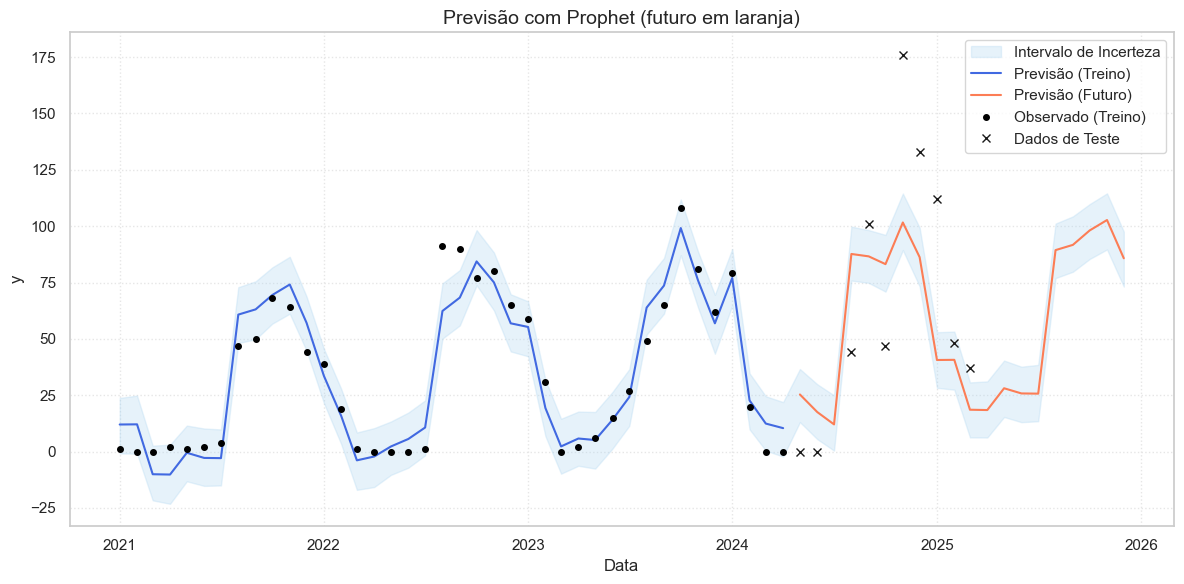

In [ ]:
df_treino['ds'] = pd.to_datetime(df_treino['ds'])
df_teste['ds'] = pd.to_datetime(df_teste['ds'])

data_limite = df_treino['ds'].max()
previsao_treino = previsao[previsao['ds'] <= data_limite]
previsao_futuro = previsao[previsao['ds'] > data_limite]

fig, ax = plt.subplots(figsize=(12, 6))

ax.fill_between(previsao['ds'], previsao['yhat_lower'], previsao['yhat_upper'],
                color='#AED6F1', alpha=0.3, label='Intervalo de Incerteza')




ax.plot(previsao_treino['ds'], previsao_treino['yhat'], color='royalblue', label='Previsão (Treino)')

ax.plot(previsao_futuro['ds'], previsao_futuro['yhat'], color='#FC7D55', label='Previsão (Futuro)')

ax.plot(df_treino['ds'], df_treino['y'], 'o', color='black', markersize=4, label='Observado (Treino)')

ax.plot(df_teste['ds'], df_teste['y'], 'xk', label='Dados de Teste')

ax.set_title('Previsão com Prophet (futuro em laranja)', fontsize=14)
ax.set_xlabel('Data')
ax.set_ylabel('y')
ax.legend()
plt.tight_layout()
plt.show()

Para melhorar ainda mais a gente podia refazer prevendo as diferenças entre os meses(porque assim a gente estabilizaria a tendência e o Prophet trabalha melhor assim)

## Conclusões:

- Regressões
    - Usar Regressões com poucos dados acaba tendo um resultado mais abaixo e pensando em produto, a cada F5 teríamos que atualizar o valor de previsão, o que pode consumir mais processamento(é mais suga também caso dê erro)
    - Por outro lado, para Regressões conseguimos juntar os dados de todas as escolas e treinar tudo de uma vez, algo que a gente não consegue nas séries

- Séries Temporais:
    - Tendo um modelo de Séries Temporais são mais fáceis de lidar porque com dados de uns 3 anos já dá pra ter uma noção legal, pelo menos com o Prophet
    - O ruim é que isso é feito para cada Escola
    - Pensando em produto, rodaríamos aqui uma vez por mês

- Juntando os dois mundos:
    - A regressão só funciona bem juntando com a série, então se quisermos algo que vá atualizando a cada F5(sinceramente não vejo tanta necessidade), o ideal é dar para regressão as colunas `yhat`, `seasonal` e `trend` e treinar igual vimos antes com o XGBoost.